# Lagaris Problem 1: 1st-Order Linear ODE IVP

## Setup

In [4]:
import datetime
from math import exp, sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from nnode1ivp import NNODE1IVP
from ode1ivp import ODE1IVP

In [5]:
%%javascript
MathJax.Hub.Config({
      TeX: { equationNumbers: { autoNumber: "AMS" } }
    });MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

## The differential equation and analytical solution

The differential equation is provided in the form (equation (27) in Lagaris (1998)):

\begin{equation}
\frac {d\psi} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) \psi =
x^3 + 2x + x^2 \frac {1+3x^2} {1+x+x^3}
\end{equation}

Rewritten in standard form:

\begin{equation}
G\left(x,\psi,\frac {d\psi}{dx}\right) = \frac {d\psi} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) \psi - x^3 - 2x - x^2 \frac {1+3x^2} {1+x+x^3} = 0
\end{equation}

The domain is $[0,1]$. The initial condition is:

\begin{equation}
\psi(0)=1
\end{equation}

The analytical solution and its first derivative are:

\begin{equation}
\psi_a(x) = x^2 + \frac {e^{-x^2/2}} {1 + x +  x^3}
\end{equation}

\begin{equation}
\frac {d\psi_a} {dx} = 2x - \frac {e^{-x^2/2} (1+x+4x^2+x^4)} {(1+x+x^3)^2}
\end{equation}

### Create the differential equation object from the problem definition file:

In [6]:
eq_name = 'lagaris_01'
ode = ODE1IVP(eq_name)

### Compute the analytical solution.

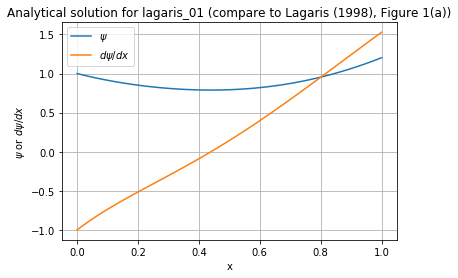

In [7]:
xmin = 0
xmax = 1
nx = 100
x = np.linspace(xmin, xmax, nx)
ya = np.vectorize(ode.yaf)(x)
dya_dx = np.vectorize(ode.dya_dxf)(x)

plt.plot(x, ya, label = "$\psi$")
plt.plot(x, dya_dx, label = "$d\psi/dx$")
plt.xlabel("x")
plt.ylabel("$\psi$ or $d\psi/dx$")
plt.grid()
plt.legend()
plt.title("Analytical solution for %s (compare to Lagaris (1998), Figure 1(a))" %
         (eq_name));

### Create the training data.

In [9]:
xmin = 0
xmax = 1
nx = 11
x_train = np.linspace(xmin, xmax, num=nx)

### Train the network.

In [10]:
net1 = NNODE1IVP(ode)
trainalg = 'BFGS'
options = {}
options['disp'] = True
opts = {}
np.random.seed(0)
print(datetime.datetime.now())
%timeit -n 1 -r 1 net1.train(x_train, trainalg=trainalg, options=options, opts=opts)
print(net1.res)

2018-10-06 12:30:56.678579


TypeError: train() got an unexpected keyword argument 'options'

Compute the solution at the training points.

In [32]:
yt = np.vectorize(net1.run)(xt)
dyt_dx = np.vectorize(net1.run_derivative)(xt)

Plot the trained solution.

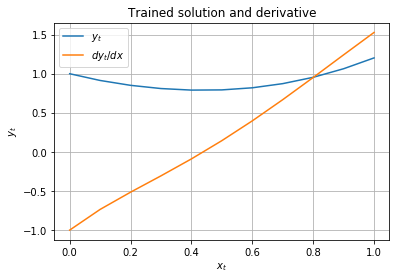

In [34]:
plt.plot(xt, yt, label = '$y_t$')
plt.plot(xt, dyt_dx, label = '$dy_t/dx$')
plt.xlabel('$x_t$')
plt.ylabel('$y_t$')
plt.grid()
plt.legend()
plt.title("Trained solution and derivative");

Plot the error in the trained solution.

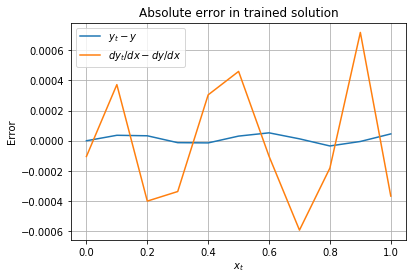

In [35]:
y = np.vectorize(yaf)(xt)
dy_dx = np.vectorize(dya_dxf)(xt)
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.grid()
plt.legend()
plt.title("Absolute error in trained solution");

## Determine the optimal model parameters

The quality of the solution will vary with the model parameters: number of training points, number of hidden nodes, and network parameter ranges. Each of these aspects will be explored in isolation below.

### Number of training points

386 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5 0.0006507107341087669 0.0010518373613082044
2.38 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
10 1.2906649813873408e-05 6.407351924874733e-05
1.53 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
20 3.0314758415543147e-05 0.0004754946053774313
5.32 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
40 1.4394362986413018e-05 0.00022180838660051526
8.93 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
80 6.045709303644298e-06 0.00012633138347493172
26.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
160 1.1590356603438895e-05 0.00020223212584858245
21.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
320 7.681065402586971e-06 0.0001588454900098014


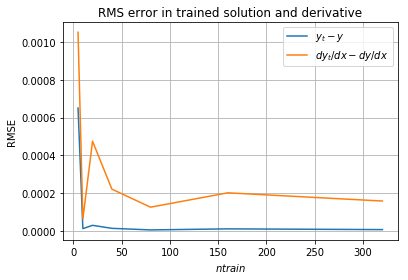

In [20]:
ntrains = [5, 10, 20, 40, 80, 160, 320]
n = len(ntrains)
rmse_yt = np.zeros(n)
rmse_dyt_dx = np.zeros(n)
for (i, ntrain) in enumerate(ntrains):
    
    # Seed the random number generator for reproducibility.
    np.random.seed(i)
    
    # Create the training points.
    xmin = 0
    xmax = 1
    xt = np.linspace(xmin, xmax, ntrain)
    
    # Create and train the network using the existing ODE object.
    net = NNODE1IVP(ode)
    %timeit -n 1 -r 1 net.train(xt, trainalg='BFGS')

    # Compute the trained solution and derivative.
    yt = np.vectorize(net.run)(xt)
    dyt_dx = np.vectorize(net.run_derivative)(xt)
    
    # Compute the analytical solution.
    ya = np.vectorize(yaf)(xt)
    dya_dx = np.vectorize(dya_dxf)(xt)
    
    # Compute the RMS error in the solution and derivative.
    rmse_yt[i] = sqrt(np.sum((yt - ya)**2)/ntrain)
    rmse_dyt_dx[i] = sqrt(np.sum((dyt_dx - dya_dx)**2)/ntrain)
    print(ntrain, rmse_yt[i], rmse_dyt_dx[i])

# Plot the results.
plt.plot(ntrains, rmse_yt, label = '$y_t-y$')
plt.plot(ntrains, rmse_dyt_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$ntrain$')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
plt.title("RMS error in trained solution and derivative");

With this initial range of training set sizes, and default values for the other parameters, the optimal training set size is 10.

### Number of hidden nodes

1.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5 4.0614246836696544e-05 0.00047387233800433504
2.38 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
10 1.2906649813873408e-05 6.407351924874733e-05
1.31 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
20 5.679858994582217e-05 0.0006529471638727642
854 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
40 5.1172400509721515e-05 0.0006122391454397093
1.02 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
80 3.580089712836858e-05 0.00041307223323301277
1.09 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
160 7.216090284640866e-05 0.0005665324508277297
1.09 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
320 3.198715809650202e-05 0.000430948002414101


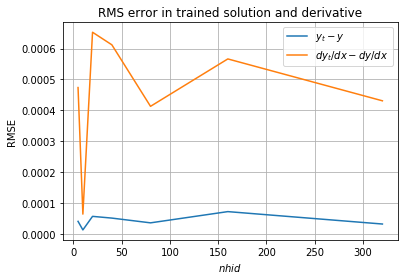

In [22]:
nhids = [5, 10, 20, 40, 80, 160, 320]
n = len(nhids)
rmse_yt = np.zeros(n)
rmse_dyt_dx = np.zeros(n)

ntrain = 10

for (i, nhid) in enumerate(nhids):
    
    # Seed the random number generator for reproducibility.
    np.random.seed(i)

    # Create the training points.
    xmin = 0
    xmax = 1
    xt = np.linspace(xmin, xmax, ntrain)

    # Create and train the network using the existing ODE object.
    net = NNODE1IVP(ode, nhid = nhid)
    %timeit -n 1 -r 1 net.train(xt, trainalg='BFGS')

    # Compute the trained solution and derivative.
    yt = np.vectorize(net.run)(xt)
    dyt_dx = np.vectorize(net.run_derivative)(xt)
    
    # Compute the analytical solution.
    ya = np.vectorize(yaf)(xt)
    dya_dx = np.vectorize(dya_dxf)(xt)
    
    # Compute the RMS error in the solution and derivative.
    rmse_yt[i] = sqrt(np.sum((yt - ya)**2)/ntrain)
    rmse_dyt_dx[i] = sqrt(np.sum((dyt_dx - dya_dx)**2)/ntrain)
    print(nhid, rmse_yt[i], rmse_dyt_dx[i])

# Plot the results.
plt.plot(nhids, rmse_yt, label = '$y_t-y$')
plt.plot(nhids, rmse_dyt_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$nhid$')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.title("RMS error in trained solution and derivative");

At this point, the optimal number of hidden nodes is 10, which is the same as the number of training points.

### Parameter ranges

The default parameter ranges are $[-1,+1]$. They can be adjusted up or down with optional arguments to the training method.

1.28 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
0.1 5.5749592206051393e-05 0.00042308413991572045
864 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
0.5 6.520078420428025e-05 0.0006298489303895343
1.34 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1 5.679858994582217e-05 0.0006529471638727642
866 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2 2.6078920811755394e-05 0.00035169397547974714
483 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4 7.189496732754838e-05 0.0005469013027779404
2.09 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8 2.1629960158351222e-05 9.329014545764747e-05
1.36 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
16 0.00013801519598411683 0.0010425169653431909
2.94 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
32 0.000256658584090407 0.002179452956566422


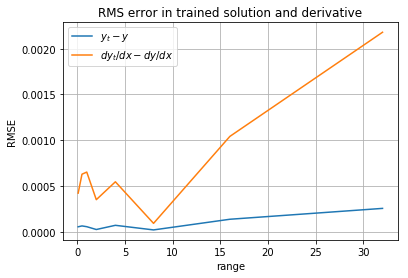

In [27]:
ranges = [0.1, 0.5, 1, 2, 4, 8, 16, 32]
n = len(ranges)
rmse_yt = np.zeros(n)
rmse_dyt_dx = np.zeros(n)

ntrain = 10

for (i, r) in enumerate(ranges):
    
    # Seed the random number generator for reproducibility.
    np.random.seed(i)

    # Create the training points.
    xmin = 0
    xmax = 1
    xt = np.linspace(xmin, xmax, ntrain)

    # Specify the parameter limits.
    opts = {}
    opts['wmin'] = -r
    opts['wmax'] = r
    opts['umin'] = -r
    opts['umax'] = r
    opts['vmin'] = -r
    opts['vmax'] = r

    # Create and train the network using the existing ODE object.
    net = NNODE1IVP(ode)
    %timeit -n 1 -r 1 net.train(xt, trainalg='BFGS', opts=opts)

    # Compute the trained solution and derivative.
    yt = np.vectorize(net.run)(xt)
    dyt_dx = np.vectorize(net.run_derivative)(xt)
    
    # Compute the analytical solution.
    ya = np.vectorize(yaf)(xt)
    dya_dx = np.vectorize(dya_dxf)(xt)
    
    # Compute the RMS error in the solution and derivative.
    rmse_yt[i] = sqrt(np.sum((yt - ya)**2)/ntrain)
    rmse_dyt_dx[i] = sqrt(np.sum((dyt_dx - dya_dx)**2)/ntrain)
    print(r, rmse_yt[i], rmse_dyt_dx[i])

# Plot the results.
plt.plot(ranges, rmse_yt, label = '$y_t-y$')
plt.plot(ranges, rmse_dyt_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('range')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
plt.title("RMS error in trained solution and derivative");

The optimal parameter range is $[-8,+8]$, but differs little from $[-1,+1]$, and so the latter will be used for simplicity.